In [49]:
import json
import fsspec
import datetime
import base64
import numpy as np
import os
import ujson
from tqdm.notebook import tqdm
import xarray as xr
from kerchunk.combine import MultiZarrToZarr
fs_local = fsspec.filesystem('file')
json_dir = '/home/taylor/data/mlwp/'

In [50]:
# open representative json
with open("/home/taylor/data/mlwp/GRAP_v100_2023011200.json", "r") as f:
    data_str = f.read()
data_str = data_str
representative_json_data = json.loads(data_str)

In [51]:
# Look at all the values in the representative json - most values stay the same
[(key, value) for key, value in representative_json_data['refs'].items()]

[('.zgroup', '{"zarr_format":2}'),
 ('.zattrs',
  '{"Conventions":"CF-1.8","creation_time":"2024-02-21T13:51:01","first_forecast_hour":"0","forecast_hour_step":"6","initialization_model":"GFS","initialization_time":"2023-01-12T00:00:00","last_forecast_hour":"240","model_name":"GraphCast","model_version":"v1","version":"1_2023-10-14"}'),
 ('apcp/.zarray',
  '{"chunks":[41,721,1440],"compressor":null,"dtype":"<f4","fill_value":null,"filters":null,"order":"C","shape":[41,721,1440],"zarr_format":2}'),
 ('apcp/.zattrs',
  '{"_ARRAY_DIMENSIONS":["time","latitude","longitude"],"long_name":"6-hr accumulated precipitation","units":"m"}'),
 ('apcp/0.0.0',
  ['s3://noaa-oar-mlwp-data/GRAP_v100/2023/0112/GRAP_v100_GFS_2023011200_f000_f240_06.nc',
   13962279256,
   170271360]),
 ('latitude/.zarray',
  '{"chunks":[721],"compressor":null,"dtype":"<f4","fill_value":null,"filters":null,"order":"C","shape":[721],"zarr_format":2}'),
 ('latitude/.zattrs',
  '{"_ARRAY_DIMENSIONS":["latitude"],"long_name":

In [52]:
# the only required changes are time/0 base64 encoded array and the variables/0.0.0 (or variables/0.0.0.0) netcdf link. 
# They're located at the same integer value in the lists. Let's test this

json_list = fs_local.glob(f"{json_dir}GRAP*json")
json_list.sort()

for file in json_list:
    with open(file, "r") as f:
        data_str = f.read()
    data_str = data_str
    json_data = json.loads(data_str)
    if json_list.index(file) > 0:
        with open(json_list[json_list.index(file) - 1], "r") as f_prev:
            prev_data_str = f_prev.read()
        prev_json_data = json.loads(prev_data_str)
        for key, value in json_data['refs'].items():
            if key in prev_json_data['refs']:
                if prev_json_data['refs'][key] != value:
                    print(f"Key: {key}, Value: {value}")


Key: apcp/.zarray, Value: {"chunks":[41,721,1440],"compressor":null,"dtype":"<f4","fill_value":null,"filters":null,"order":"C","shape":[41,721,1440],"zarr_format":2}
Key: apcp/.zattrs, Value: {"_ARRAY_DIMENSIONS":["time","latitude","longitude"],"long_name":"6-hr accumulated precipitation","units":"m"}
Key: msl/.zarray, Value: {"chunks":[41,721,1440],"compressor":null,"dtype":"<f4","fill_value":null,"filters":null,"order":"C","shape":[41,721,1440],"zarr_format":2}
Key: msl/.zattrs, Value: {"_ARRAY_DIMENSIONS":["time","latitude","longitude"],"long_name":"Pressure reduced to MSL","units":"Pa"}
Key: q/.zarray, Value: {"chunks":[41,13,721,1440],"compressor":null,"dtype":"<f4","fill_value":null,"filters":null,"order":"C","shape":[41,13,721,1440],"zarr_format":2}
Key: q/.zattrs, Value: {"_ARRAY_DIMENSIONS":["time","level","latitude","longitude"],"long_name":"Specific humidity","units":"g kg-1"}
Key: t/.zarray, Value: {"chunks":[41,13,721,1440],"compressor":null,"dtype":"<f4","fill_value":null

In [62]:
# dealing with base64

# Step 1: Decode the base64 string to bytes
print('base64 string: ', representative_json_data['refs']['time/0'])
decoded_bytes = base64.b64decode(representative_json_data['refs']['time/0'][7:])

# Step 2: Convert the bytes to an array of integers
int_array = np.frombuffer(decoded_bytes, dtype=np.int32)

# Step 3: Convert the array of integers to an array of datetime64 values
datetime_array = int_array.astype('datetime64[s]')

# Step 4: Convert the datetime64 values to seconds since 1970-1-1
# seconds_since_epoch = (datetime_array - np.datetime64('1970-01-01T00:00:00Z')).astype(int)
print('converted datetime array: ')
print(datetime_array)

reencoded_base64 = b"base64:" + base64.b64encode(datetime_array.astype('int32'))
print('back to base64: ', reencoded_base64)

decoded_again = base64.b64decode(reencoded_base64[7:])
int_array_again = np.frombuffer(decoded_again, dtype=np.int32)
datetime_array_again = int_array_again.astype('datetime64[s]')
print('back to datetime:')
print(datetime_array_again)

print('now with initialization time:')
initialization_date = datetime.datetime.strptime(json.loads(representative_json_data['refs']['.zattrs'])['initialization_time'], '%Y-%m-%dT%H:%M:%S')
hours = np.arange(0, 241, 6, dtype='timedelta64[h]')
date64 = np.datetime64(initialization_date)
result_dates = np.array(date64 + hours).astype('datetime64[s]')
print('initialization_date based datetime:')
print(result_dates)
encoded_time_array = b"base64:" + base64.b64encode(result_dates.astype('int32'))
print(encoded_time_array)

base64 string:  base64:gE2/Y+Chv2NA9r9joErAYwCfwGNg88BjwEfBYyCcwWOA8MFj4ETCY0CZwmOg7cJjAELDY2CWw2PA6sNjID/EY4CTxGPg58RjQDzFY6CQxWMA5cVjYDnGY8CNxmMg4sZjgDbHY+CKx2NA38djoDPIYwCIyGNg3MhjwDDJYyCFyWOA2clj4C3KY0CCymOg1spjACvLY2B/y2PA08tjICjMY4B8zGM=
converted datetime array: 
['2023-01-12T00:00:00' '2023-01-12T06:00:00' '2023-01-12T12:00:00'
 '2023-01-12T18:00:00' '2023-01-13T00:00:00' '2023-01-13T06:00:00'
 '2023-01-13T12:00:00' '2023-01-13T18:00:00' '2023-01-14T00:00:00'
 '2023-01-14T06:00:00' '2023-01-14T12:00:00' '2023-01-14T18:00:00'
 '2023-01-15T00:00:00' '2023-01-15T06:00:00' '2023-01-15T12:00:00'
 '2023-01-15T18:00:00' '2023-01-16T00:00:00' '2023-01-16T06:00:00'
 '2023-01-16T12:00:00' '2023-01-16T18:00:00' '2023-01-17T00:00:00'
 '2023-01-17T06:00:00' '2023-01-17T12:00:00' '2023-01-17T18:00:00'
 '2023-01-18T00:00:00' '2023-01-18T06:00:00' '2023-01-18T12:00:00'
 '2023-01-18T18:00:00' '2023-01-19T00:00:00' '2023-01-19T06:00:00'
 '2023-01-19T12:00:00' '2023-01-19T18:00:00' '2023-01-20T00

Which means that we need two things: the URI to plug into each variable, a base64 encoded seconds since 1970-1-1, and an initialization_time for the .zattrs dict. For other models, we will supplant the .zattrs model_name, model_version, initialization_model, etc. as needed. The only piece that cannot be replicated is the creation_time. There might be a performant way to get that from the netCDF metadata in AWS, but it is ultimately not necessary for this use case.

Either way, one json per model should be enough to generate all jsons, and by extension performantly load any and all combinations of these files.

Let's try to combine every single Graphcast (GRAP_v100) run into one json file.

In [54]:
# create an s3 fsspec filesystem
fs_s3 = fsspec.filesystem('s3', anon=True)

# create a list of all the files in the Graphcast bucket
flist = fs_s3.glob('s3://noaa-oar-mlwp-data/GRAP_v100/**/*06.nc')
flist = sorted(["s3://" + f for f in flist])
len(flist)

3657

This makes sense, as there is only one 2021 date with 2 runs and a mix of dates either with 2 or 4 runs.

We can run a serial loop that edits the json; the time to beat for one year of data is 135 minutes.

In [63]:
# make a copy to avoid changing the original data
dummy_json_data = representative_json_data.copy()

# create new json directory to avoid overwriting the original json files
new_json_dir = '/home/taylor/data/mlwp/test_json/'
if not os.path.exists(new_json_dir):
    os.mkdir(new_json_dir)

# set up variable list for graphcast:
variable_list = ['u10/0', 'u/0', 'v10/0', 'v/0', 'apcp/0', 'msl/0', 't/0', 't2/0', 'q/0', 'w/0', 'z/0']
for file in tqdm(flist):
    # Extract the date from the file URI
    date_str = file.split('/')[-1].split('_')[3]
    initialization_date = datetime.datetime.strptime(date_str, '%Y%m%d%H')
    for key, value in dummy_json_data['refs'].items():
        if '.zattrs' in key:
            zattrs_dict = json.loads(value)
            zattrs_dict['initialization_time'] = initialization_date.strftime('%Y-%m-%dT%H:%M:%S')
            dummy_json_data['refs'][key] = json.dumps(zattrs_dict)
        if key == 'time/0':
            # 6 hourly steps from initialization time
            hours = np.arange(0, 241, 6, dtype='timedelta64[h]')
            date64 = np.datetime64(initialization_date)
            result_dates = np.array(date64 + hours).astype('datetime64[s]')
            encoded_time_array = b"base64:" + base64.b64encode(result_dates.astype('int32'))
            dummy_json_data['refs'][key] = encoded_time_array
        if any(substring in key for substring in variable_list):
            dummy_json_data['refs'][key][0] = file
    with open(f"{new_json_dir}GRAP_v100_{initialization_date.strftime('%Y%m%d%H')}.json", "w") as f:
        f.write(ujson.dumps(dummy_json_data, reject_bytes=False))


  0%|          | 0/3657 [00:00<?, ?it/s]

Serially that took 0.7 seconds... compared to 135 minutes for 1/4 of the data. Let's validate if it actually works with a MultiZarrToZarr call

In [72]:
new_json_list = fs_local.glob(f"{new_json_dir}GRAP*json")

mzz = MultiZarrToZarr(new_json_list,
    remote_protocol='s3',
    remote_options={'anon':True},
    coo_map={'init_time':'attr:initialization_time'},
    concat_dims=['init_time'],
    identical_dims = ['latitude', 'longitude', 'level'],)

d = mzz.translate()

In [64]:
backend_args = {"consolidated": False, "storage_options": {"fo": d, "remote_protocol": "s3","remote_options": {"anon": True}}}
t = xr.open_dataset("reference://", engine="zarr", backend_kwargs=backend_args)

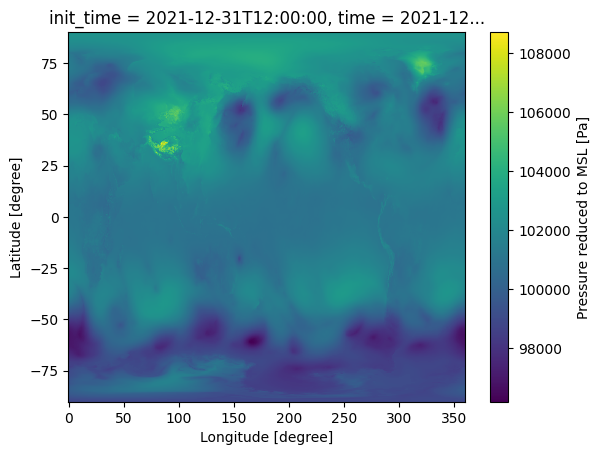

In [67]:
t['msl'].isel(init_time=0,time=0).plot()

I was able to combine every single forecast and subset a plot in 20 seconds or so. Now if I saved the multizarr reference dict as a json and tried again...

In [69]:
with fs_local.open(f'{json_dir}GRAP_v100_combined_all.json', 'wb') as f:
    f.write(ujson.dumps(d).encode())

In [70]:
fo = f'{json_dir}GRAP_v100_combined_all.json'
ds = xr.open_dataset("reference://", engine="zarr", backend_kwargs={
                    "consolidated": False,
                    "storage_options": {"fo": fo, "remote_protocol": "s3","remote_options": {"anon": True}}
                    })
ds

<xarray.Dataset> Size: 51TB
Dimensions:    (init_time: 3590, time: 41, latitude: 721, longitude: 1440,
                level: 13)
Coordinates:
  * init_time  (init_time) object 29kB '2021-12-31T12:00:00' ... '2025-01-03T...
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * level      (level) int32 52B 1000 925 850 700 600 500 ... 250 200 150 100 50
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 328B 2021-12-31T12:00:00 ... 2022-01-10T...
Data variables:
    apcp       (init_time, time, latitude, longitude) float32 611GB ...
    msl        (init_time, time, latitude, longitude) float32 611GB ...
    q          (init_time, time, level, latitude, longitude) float32 8TB ...
    t          (init_time, time, level, latitude, longitude) float32 8TB ...
    t2         (init_time, time, latitude, longitude) float32 611GB ...
    u          (init_time, time, level, latitude, longitude) float32 8TB ...
    u10        (init_time, time, latitude, longitude) float32 611GB ...
    v          (init_time, time, level, latitude, longitude) float32 8TB ...
    v10        (init_time, time, latitude, longitude) float32 611GB ...
    w          (init_time, time, level, latitude, longitude) float32 8TB ...
    z          (init_time, time, level, latitude, longitude) float32 8TB ...
Attributes:
    Conventions:           CF-1.8
    creation_time:         2024-02-21T13:51:01
    first_forecast_hour:   0
    forecast_hour_step:    6
    initialization_model:  GFS
    initialization_time:   2021-12-31T12:00:00
    last_forecast_hour:    240
    model_name:            GraphCast
    model_version:         v1
    version:               1_2023-10-14

Knocked it down to under 8 seconds when loaded. Overall, 20 seconds total end-to-end